# ENGRI 1120 Lab 8: Analysis of continuous stirred tank reactor with a single irreversible chemical reaction

### Introduction
Fill me in

#### Problem setup
The volume of the reactor $V$ = 5L. Stream 1 has a volumetric flow rate $\dot{V}_{1}$ = 200 mL/h and Stream 2 has a volumetric flow rate $\dot{V}_{2}$ = 300 mL/h. The concentration(s) of $A$ in the stream 1 is $C_{1,1}$ = 50 mmol/L, there is no $B$ and $C$ in stream $1$. The concentration(s) of $B$ in the stream 2 is $C_{2,2}$ = 75 mmol/L, there is no $A$ or $C$ in stream $2$. The rate constant for rate $1$ is given by: $k_{1}$ = 0.56 units. 

### Lab setup
The code block below installs (and loads) [Julia](https://julialang.org) packages that we use to solve the species concentration balance equations.

In [1]:
import Pkg; Pkg.activate("."); Pkg.resolve(); Pkg.instantiate();

  Activating project at `~/Desktop/julia_work/ENGRI-1120-IntroToChemE-Example-Notebooks/labs/lab-8-fun-w-mass-action-kinetics`
  No Changes to `~/Desktop/julia_work/ENGRI-1120-IntroToChemE-Example-Notebooks/labs/lab-8-fun-w-mass-action-kinetics/Project.toml`
  No Changes to `~/Desktop/julia_work/ENGRI-1120-IntroToChemE-Example-Notebooks/labs/lab-8-fun-w-mass-action-kinetics/Manifest.toml`


In [2]:
# load required packages 
using DifferentialEquations
using Optim
using Plots
using Colors

# setup paths -
const _ROOT = pwd();
const _PATH_TO_FIGS = joinpath(_ROOT, "figs");

#### Load the Lab 8 code library
The call to the `include` function loads the `ENGRI-1120-Lab-6-CodeLib.jl` library into the notebook; the library contains functions we can use during the lab. In particular:

#### Functions
* The `kinetics(x::Array{Float64,1}, k::Float64) -> Float64` function computes the value of reaction rate $\hat{r}_{1}$ given the concentrations in the `x::Array{Float64,1}` array and the rate constant `k::Float64`.
* The `evaluate(model::Dict{String, Any}; tspan::Tuple{Float64, Float64} = (0.0,20.0), Δt::Float64 = 0.01) --> (T,X)` computes the numerical solution of the concentration balances; the time is stored in the `T::Array{Float64,1}` array. The concentrations are stored in the `X::Array{Float64,2}` array; each row of `X::Array{Float64,2}` corresponds to a time point, while each column holds the concentration of a species
* The `objfunc(x::Array{Float64,1}, model::Dict{String, Any}) --> Float64` function is called by `Optim` to estimate the `residual` of the concentration balances.

In [11]:
include("ENGRI-1120-Lab-8-CodeLib-Soln.jl");

In [4]:
# setup some constants from the problem -
V = 5.0; # units: L
V̇₁ = 200.0*(1/1000); # units: L/hr
V̇₂ = 300.0*(1/1000); # units: L/hr

# rate constant -
k₁ = 0.56;

# Feed concentrations -
A_in = 50.0; # units: mmol/L
B_in = 75.0; # units: mmol/L
C_in = 0.0;  # units: mmol/L (no product in any feed)

# initial condition in the reactor -
xₒ = [0.1, 0.1, 1e-6];

### Setup task: Formulate the stoichiometric array, the composition array and the dilution vector

In [5]:
# setup stoichiometric array -
S = [
    -2.0 ; # 1 A
    -1.0 ; # 2 B
     1.0 ;  # 3 C
];

# setup the dilution rate vector -
D = [
    (V̇₁/V)        ; # 1 D₁ units: 1/hr
    (V̇₁/V)        ; # 2 D₂ units: 1/hr
    ((V̇₁ + V̇₂)/V) ; # 3 D₃ units: 1/hr
];

# setup concentration array -
CM = [
    A_in 0.0 0.0 ; # species 1
    0.0 B_in 0.0 ; # species 2
    0.0 0.0 0.0  ; # species 3
];

### Setup task: Put all our data into a `model` dictionary

In [6]:
# initialize Dict data structrure -
model = Dict{String, Any}();

# constants from the problem -
model["number_of_dynamic_states"] = 3;
model["initial_condition_array"] = xₒ;

# data set by you -
model["S"] = S;
model["k"] = k₁;
model["D"] = D;
model["CM"] = CM;

### a) Estimate of the dynamic exit concentration for a constant feed

In [7]:
(T, X) = evaluate(model; tspan=(0.0, 30.0));

### b) Estimate the steady state exit composition as an optimization problem

In [8]:
# Setup the objective function (this is the function that we will minimize)
OF(x) = objfunc(x, model)

# setup bounds -
L = [0.0, 0.0, 0.0];  # lower bound is zero (concentration ≥ 0)
U = [Inf, Inf, Inf];  # upper bound is Inf (concentration ≤ ∞)
    
# call the optimizer -
opt_result = optimize(OF, L, U, xₒ, Fminbox(NelderMead()))

 * Status: success

 * Candidate solution
    Final objective value:     6.248246e-10

 * Found with
    Algorithm:     Fminbox with Nelder-Mead

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 6.76e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    3
    f(x) calls:    651
    ∇f(x) calls:   1


In [9]:
nm_soln = Optim.minimizer(opt_result)

3-element Vector{Float64}:
  0.2954988377892016
 20.148022595731934
  9.852165444819672

### c) Visualize the dynamic and steady-state solutions

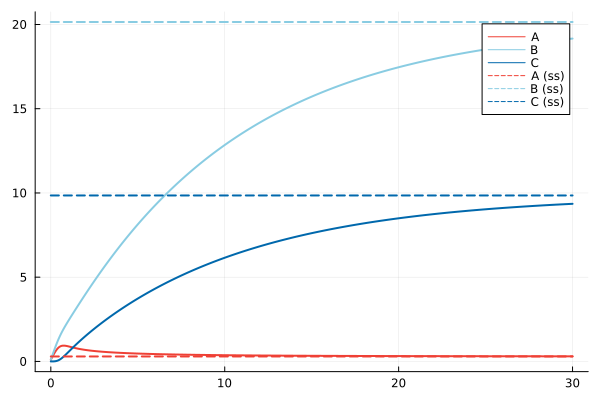

In [10]:
# grab the steady-state solutions -
x̄₁ = nm_soln[1];
x̄₂ = nm_soln[2];
x̄₃ = nm_soln[3];

# how many simulation data points do we have?
Nₛ = length(T);

# plot the simulation -
plot(T,X[:,1],lw=2,c=colorant"#EF4035", label="A")
plot!(T,X[:,2],lw=2,c=colorant"#89CCE2", label="B")
plot!(T,X[:,3],lw=2,c=colorant"#0068AC", label="C")

# plot the steady-states -
plot!(T, x̄₁*ones(Nₛ), lw=2,c=colorant"#EF4035", label="A (ss)", ls=:dash) 
plot!(T, x̄₂*ones(Nₛ), lw=2,c=colorant"#89CCE2", label="B (ss)", ls=:dash) 
plot!(T, x̄₃*ones(Nₛ), lw=2,c=colorant"#0068AC", label="C (ss)", ls=:dash) 